In [1]:
import pandas as pd
from os.path import dirname, realpath, join, isfile
from nb_utils import get_ps1_or_ipaddress, read_pcap_fields_from_txts, download_roku_channel_details, ROKU_MACS

In [2]:
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(16,9)})

In [3]:
ROOT_PROJ_DIR = dirname(dirname(dirname(dirname(realpath('__file__')))))
DATA_DIR = join(ROOT_PROJ_DIR, "data/pcap_analysis/roku-channel-surfer/2018-09-27")
HTTP_REQS_DIR = join(DATA_DIR, "http")
DNS_QUERIES_DIR = join(DATA_DIR, "dns")
HTTP_CSV = join(DATA_DIR, "roku-2018-09-27-requests.csv")
DNS_CSV = join(DATA_DIR, "roku-2018-09-27-dns.csv")

### Load channel details
- We only channels details to add helper columns to request dataframe
- Once we build and store the request details, we don't actually need to do this

In [4]:
channel_df = download_roku_channel_details()
channel_df.head()

,_category,_scrape_ts,accessCode,desc,name,payment,price,rankByWatched,rating,thumbnail
id,,,,,,,,,,
12,movies-tvs,1537037970,101D4DEA,Watch TV shows and movies recommended just for...,Netflix,None,0,1,75.890121,http://channels.roku.com/images/f5e60d25f2c944...
2285,movies-tvs,1537037970,hulu,Stream all your TV in one place with Hulu. Get...,Hulu,None,0,3,74.931961,https://image.roku.com/developer_channels/prod...
13,movies-tvs,1537037970,8C42649C,Prime members can watch thousands of movies an...,Prime Video,None,0,4,73.552605,https://image.roku.com/developer_channels/prod...
46041,movies-tvs,1537037970,SlingTV,"Sling TV is Live TV, Only Better. The #1 Live ...",Sling TV,None,0,5,68.119362,https://image.roku.com/developer_channels/prod...
23048,movies-tvs,1537037970,twctv,"With Spectrum TV, you can enjoy up to 250 live...",Spectrum TV,None,0,6,64.740654,https://image.roku.com/developer_channels/prod...


## Load DNS details
- Load the DNS details from the CSV or build from scratch

In [5]:
if isfile(DNS_CSV):
    # load from csv if we already built the dataframe
    df = pd.read_csv(DNS_CSV, sep='\t', encoding='utf-8')
else:
    # we use `extract_fields.sh` script to extract the following
    # eth.src, dns.qry.name, dns.qry.type 
    # here we read the extracted fields into a dataframe
    dns_fields = [dns_fields for dns_fields in read_pcap_fields_from_txts(DNS_QUERIES_DIR)]
    df = pd.DataFrame(dns_fields, columns=['channel_id', 'start_ts', 'command', 'select_idx', 'eth_src', 'host', 'query_type'])
    # we have some packets from the RPi's, filter them out
    df = df[df.eth_src.isin(ROKU_MACS)]
    df['channel_name'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['name'])
    df['rank'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['rankByWatched'])
    df['category'] = df['channel_id'].map(lambda x: channel_df.loc[int(x)]['_category'])
    df['domain'] = df['host'].map(lambda x: get_ps1_or_ipaddress("http://" + x))
    df.to_csv(DNS_CSV, index=False, sep='\t', encoding='utf-8')
    

In [6]:
df.head()

,channel_id,start_ts,command,select_idx,eth_src,host,query_type,channel_name,rank,category,domain
0,145651,1538303764,launch,0,d8:31:34:22:e6:ff,api.roku.com,1,BIO TV,2068,movies-tvs,roku.com
1,145651,1538303764,launch,0,d8:31:34:22:e6:ff,wwwimg.roku.com,1,BIO TV,2068,movies-tvs,roku.com
2,145651,1538303764,launch,0,d8:31:34:22:e6:ff,api.sr.roku.com,1,BIO TV,2068,movies-tvs,roku.com
3,145651,1538303764,launch,0,d8:31:34:22:e6:ff,cigars.roku.com,1,BIO TV,2068,movies-tvs,roku.com
4,145651,1538303764,launch,0,d8:31:34:22:e6:ff,cigars.roku.com,1,BIO TV,2068,movies-tvs,roku.com


### DNS Queries - overview

In [7]:
print "%d DNS queries to %d distinct domains from %s distinct channels" %\
    (len(df), df.domain.nunique(), df.channel_id.nunique())

16337 DNS queries to 845 distinct domains from 1508 distinct channels


### Top domains
- domains resolved by most channels

In [8]:
df.drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
600,roku.com,1183
362,ifood.tv,329
328,google-analytics.com,243
242,doubleclick.net,209
390,irchan.com,183
619,scorecardresearch.com,163
789,vimeo.com,158
654,spotxchange.com,133
790,vimeocdn.com,119
834,yumenetworks.com,113


### Top domains - Kids and family channels

In [9]:
df[df.category == "kids-family"].drop_duplicates(subset=["channel_id", "domain"]).\
    groupby(["domain"]).size().reset_index(name="# channels").\
    sort_values(by=['# channels'], ascending=False).head(10)

,domain,# channels
129,roku.com,388
72,ifood.tv,272
45,doubleclick.net,69
148,spotxchange.com,62
136,scorecardresearch.com,47
186,yumenetworks.com,37
63,google-analytics.com,37
124,ravm.tv,28
151,superawesome.tv,27
76,innovid.com,23


### Channels resolving the most domains

In [10]:
df_n_domains_by_channel = df.drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_channel.head(10)

,channel_name,rank,# domains
11,8ctave HD,936,66
67,American Cowboy Classics,2267,62
1425,WatchFreeForeignFlix,1100,47
87,AsianCrush,277,43
1422,WatchFreeActionThrillerFlix,738,40
712,KMTV - Watch K-Pop,2185,38
855,Midnight Pulp,315,37
1424,WatchFreeFlix,81,37
638,Horror Films by Fawesome.tv,983,36
1423,WatchFreeDocumentaryFlix,990,33


### Kids and family channels contacting the most domains

In [11]:
df_n_domains_by_kids_channel = df[df.category == "kids-family"].drop_duplicates(subset=["channel_name", "domain", "rank"]).\
    groupby(["channel_name", "rank"]).size().reset_index(name="# domains").\
    sort_values(by=['# domains'], ascending=False)
df_n_domains_by_kids_channel.head(10)

,channel_name,rank,# domains
351,Superman 3D,1708,25
397,Toontime TV,1641,22
296,Only Animation TV,3207,21
61,Cartoon Club LIVE,1570,21
316,Popcornflix Kids,268,20
394,Toontime 2,2170,20
335,So Yummy,2637,18
43,Blossom,3085,18
30,BabyFirst Español,1834,17
60,Cartoon Club,1637,17


### Effect of popularity (rank)
- Do popular channels resolve more domains?

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


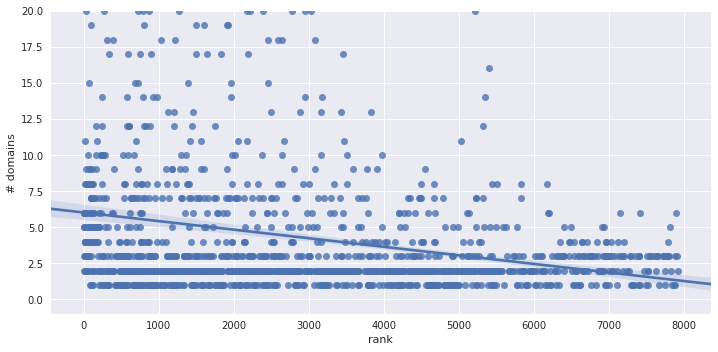

In [12]:
ax = sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_channel, size=5, aspect=2)
ax.set(ylim=(-1, 20))

### Effect of popularity (rank) - Kids and family channels

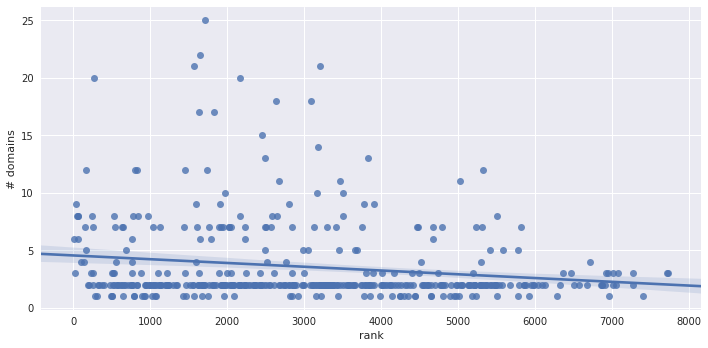

In [13]:
sns.lmplot(x="rank", y="# domains", data=df_n_domains_by_kids_channel, size=5, aspect=2)